

## Experiment Details
__Experiment Id__ : 010 \
__Target__ : make visualizations on model interoperability \
__Solution__ : 
- visualize intermediate layer output
- visualize Conv1D layer weights with flow of output

__Empirical result__ : 
- show expected region attention in the operation by both weights and outputs

---
Implementation

In [ ]:
! pip install shap

In [71]:
import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras import losses

from tqdm import tqdm
import math
import random 
import pandas as pd 
import numpy as np
from skimage import io, transform 
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import json
from digit_generator import random_digit_sequence_generator
import shap

import neptune.new as neptune

---
Set global variables

In [2]:
with open("./digit_configurations.json", "r", encoding="utf-8") as f0:
        config_file = json.load(f0)

In [3]:
gpu_available = tf.config.list_physical_devices('GPU')
gpu_available

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
IMAGE_SIZE = (128,48)
DATA_BS = 10
DATA_N = 10
LR = 0.005
EPOCHS = 10
BS = 32

In [5]:
run = neptune.init(
    project="nipdep/ACRA",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNWJjMDdhNC05NWY5LTQwNWQtYTQyNi0zNjNmYmYwZDg3M2YifQ==",
)  # your credentials

https://app.neptune.ai/nipdep/ACRA/e/AC-29
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [6]:
neptune_params = {
    'description': 'experiment-005',
    'image size': IMAGE_SIZE,
    '# digits in a sticker': DATA_N,
    'batch size': DATA_BS,
    'starting LR': LR,
    '# epochs': EPOCHS,
    'dataset version': 'V0'
}

---
Dataset & Dataloader 

In [7]:
class SynthDataset(object):
    def __init__(self, BS=32, image_size=(24, 24), anns=10):
        self.bs = BS
        self.image_size = image_size
        self.n = anns 

    def data_creator(self, n):
        nbs = n//self.bs
        digit_gen = random_digit_sequence_generator(self.n, config_file, batch=self.bs, image_size=self.image_size)
        ret_arr, ret_ann = next(digit_gen)
        for _ in range(nbs):
            arr, ann = next(digit_gen)
            ret_arr.extend(arr)
            ret_ann.extend(ann)
        ret_arr = np.array(ret_arr)[..., 0]
        return ret_arr, ret_ann

    def generate(self, num_sample):

        def label_generator(index):
            index = int(index[0])
            delta = 1
            theta = 0
            y_start_points = [max(0,i['bbox'][2]-0.5-delta-theta) for i in df[index]['annotations']]
            y_end_points = [min(i['bbox'][2]-0.5+delta, self.image_size[0]) for i in df[index]['annotations']]
            classes = [int(i['category_id']) for i in df[index]['annotations']]
            output = list(zip(y_start_points, y_end_points, classes))
            output_array = np.array(output)
            full_array = np.ones((self.n, 3))*-1
            output_shape = output_array.shape 
            full_array[:output_shape[0], :output_shape[1]] = output_array
            return full_array

        data, df = self.data_creator(num_sample)
        indexs = np.arange(data.shape[0]).reshape(-1, 1)
        dataset_ann = np.apply_along_axis(label_generator, 1, indexs)
        ret_tensor = tf.convert_to_tensor(np.swapaxes(data, 1, 2), dtype=tf.float32)
        ind_tensor = tf.convert_to_tensor(dataset_ann[..., -1], dtype=tf.int32)
        dataset = tf.data.Dataset.from_tensor_slices((ret_tensor, ind_tensor))
        return dataset
    

In [8]:
# test the dataset & sample
dataset_gen = SynthDataset(BS=32, image_size=IMAGE_SIZE)
sample_dataset = dataset_gen.generate(100)
for i in sample_dataset.take(1):
    image, labels = i
    print(image.shape, labels.shape)

print("dataset element spec > ", sample_dataset.element_spec)

(128, 48) (10,)
dataset element spec >  (TensorSpec(shape=(128, 48), dtype=tf.float32, name=None), TensorSpec(shape=(10,), dtype=tf.int32, name=None))


[0 9 9 4 2 6 5 5 9 7]


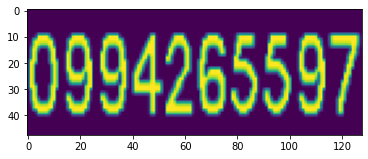

In [9]:
plt.imshow(image.numpy().T)

print(labels.numpy())

In [10]:
train_dataset = dataset_gen.generate(10000)
train_loader = train_dataset.shuffle(buffer_size=1000).batch(BS, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)
# validation 
valid_dataset = dataset_gen.generate(500)
valid_loader = valid_dataset.batch(BS, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)

---
Model Defining

In [11]:
class RecNet(tf.keras.Model):
	def __init__(self, bs=16, input_size=(128, 48), n_classes=10, h_cell=64, max_obj=15, linear_k=3):
		super().__init__()
		self.bs = bs
		self.input_size = input_size
		self.n_classes = n_classes  # LSTM module projection size
		self.h_cell = h_cell  # LSTM hidden size
		self.max_obj = max_obj
		self.linear_k = linear_k
		self.model = self.build_model(
			self.input_size, self.h_cell, self.n_classes, self.max_obj, self.linear_k)

		self.scce = losses.SparseCategoricalCrossentropy(from_logits=False,)

		self.loss_metric = tf.keras.metrics.Mean(name="loss")
		self.acc_metric = tf.keras.metrics.Mean(name="accuracy")
		self.acc_mat = tf.keras.metrics.Accuracy()
		neptune_params.update({
			'model in details': '',
			'intermediate LSTM size': self.h_cell,
			'n_classes': self.n_classes,
			'max obj per sticker': self.max_obj,
			'1DConv activation': 'tanh'
		})

	def build_model(self, input_shape=(128, 48), h_cell=32, n_classes=10, n_obj=10, linear_k=3):
		x_input = layers.Input(shape=input_shape, name='input_layer')
		forward_layer = layers.LSTM(h_cell//2, return_sequences=True)
		x = layers.Bidirectional(forward_layer, input_shape=self.input_size, name='lstm_encoder')(x_input)
		x = layers.LSTM(n_classes, activation='tanh',
						return_sequences=True, go_backwards=True, name='lstm_projector')(x)
		x = layers.Conv1D(n_classes, linear_k, activation='tanh', name='projection_encoder')(x)
		x = tf.transpose(x, perm=[0, 2, 1])
		x = layers.Conv1D(n_obj, 1, activation='tanh', name='region_encoder')(x)
		x = tf.transpose(x, perm=[0, 2, 1])
		x_output = layers.Activation('softmax')(x)

		model = tf.keras.Model(inputs=x_input, outputs=x_output)
		return model


	@property
	def metrics(self):
		return [self.loss_metric, self.acc_mat]

	def calculate_loss(self, target, pred):
		target = tf.reshape(target, shape=(-1))
		pred = tf.reshape(pred, shape=(-1, self.n_classes))
		loss = self.scce(target, pred)

		y_hat = tf.argmax(pred, axis=-1)
		acc = self.acc_mat(y_hat, target)
		return loss, acc

	def call(self, x):
		full_out = self.model(x)
		return full_out

	def train_step(self, batch_data):
		x, target = batch_data
		with tf.GradientTape() as tape:
			pred = self(x, training=True)
			# print(pred.shape, pred)
			loss, acc = self.calculate_loss(target, pred)

		gradient = tape.gradient(loss, self.trainable_variables)
		self.optimizer.apply_gradients(zip(gradient, self.trainable_variables))
		self.loss_metric.update_state(loss)
		self.acc_metric.update_state(acc)
		run['train/loss'].log(loss)
		run['train/acc'].log(acc)
		return {
			"loss": self.loss_metric.result(),
			"accuracy": self.acc_mat.result(),
		}

	def test_step(self, batch_data):
		x, target = batch_data

		pred = self(x, training=False)
		loss, acc = self.calculate_loss(target, pred)

		self.loss_metric.update_state(loss)
		self.acc_metric.update_state(acc)
		run['eval/loss'].log(loss)
		run['eval/acc'].log(acc)
		return {
			"loss": self.loss_metric.result(),
			"accuracy": self.acc_mat.result(),
		}


In [12]:
recNet = RecNet(input_size=IMAGE_SIZE,
                bs=BS,
                n_classes=10,
                h_cell=32,
                max_obj=10,
                linear_k=3)

In [13]:
recNet.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 48)]         0         
                                                                 
 lstm_encoder (Bidirectional  (None, 128, 32)          8320      
 )                                                               
                                                                 
 lstm_projector (LSTM)       (None, 128, 10)           1720      
                                                                 
 projection_encoder (Conv1D)  (None, 126, 10)          310       
                                                                 
 tf.compat.v1.transpose (TFO  (None, 10, 126)          0         
 pLambda)                                                        
                                                                 
 region_encoder (Conv1D)     (None, 10, 10)            1270  

---
Set up model training details

In [14]:
def lr_time_based_decay(epoch, lr):
    decay = 0.001
    return lr * 1 / (1 + decay * epoch)

def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10.0
    return LR * math.pow(drop_rate, math.floor(epoch/epochs_drop))

def lr_exp_decay(epoch, lr):
    k = 0.1
    return LR * math.exp(-k*epoch)

decay_steps = 1000
# lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
#     LR, decay_steps)

lr_decaying_callback = tf.keras.callbacks.LearningRateScheduler(lr_step_decay, verbose=1)

In [15]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
                            monitor='val_accuracy',
                            min_delta=0,
                            patience=2,
                            restore_best_weights=True
                        )

In [16]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LR,
)

In [17]:
neptune_params.update({
    'trainable params': 11_620,
    'optimizer': 'adam',
    'is early-stopping added': 'Yes',
    'early stopping method': 'val-accuracy | patience : 2',
    'is lr decay added': 'yes',
    'LR decay method': 'step-decay'
})

In [18]:
# model = RecNet(bs=BS)
model = RecNet(input_size=IMAGE_SIZE,
                bs=BS,
                n_classes=10,
                h_cell=32,
                max_obj=10,
                linear_k=3)
model.compile(optimizer, loss='categorical_crossentropy', run_eagerly=True)

In [19]:
for i in valid_loader.take(1):
    test_image, test_labels = i

In [20]:
sample_output = model(test_image)

In [21]:
sample_output.shape

TensorShape([32, 10, 10])

In [22]:
test_labels.shape

TensorShape([32, 10])

In [23]:
model.calculate_loss(test_labels, sample_output)

(<tf.Tensor: shape=(), dtype=float32, numpy=2.3042781>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.115625>)

In [24]:
## setting the model params
run['parameters'] = neptune_params

In [25]:
model.fit(
    train_loader,
    epochs=EPOCHS,
    validation_data=valid_loader,
    callbacks=[earlystopping_callback,
               lr_decaying_callback]
)
run.stop()


Epoch 00001: LearningRateScheduler setting learning rate to 0.005.
Epoch 1/10
313/313 [==============================] - 66s 202ms/step - loss: 0.9404 - accuracy: 0.9325 - val_loss: 0.8003 - val_accuracy: 0.9994 - lr: 0.0050

Epoch 00002: LearningRateScheduler setting learning rate to 0.005.
Epoch 2/10
313/313 [==============================] - 57s 181ms/step - loss: 0.7992 - accuracy: 0.9994 - val_loss: 0.7982 - val_accuracy: 0.9998 - lr: 0.0050

Epoch 00003: LearningRateScheduler setting learning rate to 0.005.
Epoch 3/10
313/313 [==============================] - 56s 179ms/step - loss: 0.8027 - accuracy: 0.9980 - val_loss: 0.7982 - val_accuracy: 0.9996 - lr: 0.0050

Epoch 00004: LearningRateScheduler setting learning rate to 0.005.
Epoch 4/10
313/313 [==============================] - 56s 179ms/step - loss: 0.7980 - accuracy: 0.9995 - val_loss: 0.7980 - val_accuracy: 0.9998 - lr: 0.0050
Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 95 operations to synchronize with Neptune. Do not kill this process.


All 95 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/nipdep/ACRA/e/AC-29


---
Model Prediction & Evaluation

In [26]:
# Generate test dataset 
test_dataset = dataset_gen.generate(100)
test_loader = valid_dataset.batch(BS, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)

__build GradCAM model__

In [27]:
for layer in model.model.layers:
    print(layer.name)

input_layer
lstm_encoder
lstm_projector
projection_encoder
tf.compat.v1.transpose_2
region_encoder
tf.compat.v1.transpose_3
activation_1


In [28]:
## model major layers > ['lstm_encoder', 'lstm_projector', 'projection_encoder', 'region_encoder']
interesting_layer = 'lstm_projector'
grad_model = tf.keras.models.Model(inputs=[model.model.inputs], outputs=[model.model.get_layer(interesting_layer).output, model.model.output])

* Individual prediction & labeling 

In [29]:
for s in test_dataset.take(10):
    test_image, test_label = s
     
test_class = test_label.numpy()

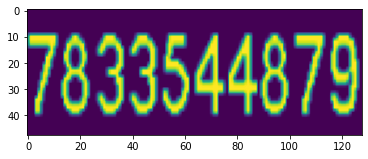

In [30]:
plt.imshow(test_image.numpy().T)

In [31]:
test_class

array([7, 8, 3, 3, 5, 4, 4, 8, 7, 9])

---
__Vis. LSTM projector__

In [32]:
interesting_layer = 'lstm_projector'
grad_model = tf.keras.models.Model(inputs=[model.model.inputs], outputs=[model.model.get_layer(interesting_layer).output, model.model.output])


In [33]:
sample = tf.expand_dims(test_image, axis=0)
sample_lstm_enc_output, sample_output = grad_model(sample)
print(sample_lstm_enc_output.shape)

(1, 128, 10)


<AxesSubplot:>

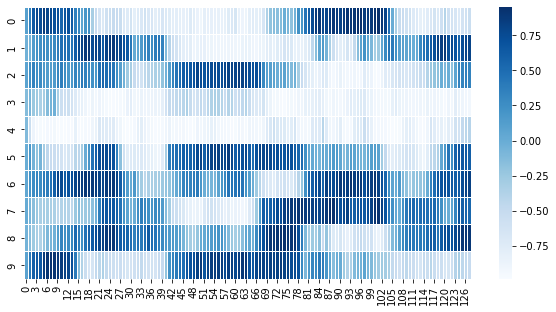

In [34]:
fig = plt.figure(figsize=(10,5))
sns.heatmap(data=np.squeeze(sample_lstm_enc_output.numpy()).T, linewidths=1, cmap='Blues')

_output of the `lstm_projection` layer for the above sample image_

---
#### Projection_encoder layer
__Vis. layer weights__

In [35]:
interesting_layer = 'projection_encoder'

In [36]:
layer_weights = model.model.get_layer(interesting_layer).get_weights()
print(f"W shape : {layer_weights[0].shape} | b shape : {layer_weights[1].shape}")

W shape : (3, 10, 10) | b shape : (10,)


bais of the layer >  [0.24632855 0.2174186  0.10833265 0.20438074 0.23541093 0.28570443
 0.20108254 0.23014586 0.00556361 0.09654685]


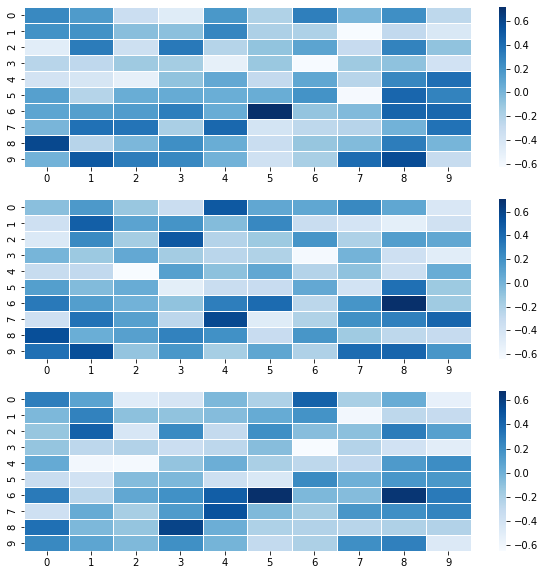

In [37]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
sns.heatmap(ax=ax1, data=np.squeeze(layer_weights[0][0]), linewidths=1, cmap='Blues')
sns.heatmap(ax=ax2, data=np.squeeze(layer_weights[0][1]), linewidths=1, cmap='Blues')
sns.heatmap(ax=ax3, data=np.squeeze(layer_weights[0][2]), linewidths=1, cmap='Blues')
print("bais of the layer > ", layer_weights[1])

__Vis. layer output__

In [38]:
interesting_layer = 'projection_encoder'
grad_model = tf.keras.models.Model(inputs=[model.model.inputs], outputs=[model.model.get_layer(interesting_layer).output, model.model.output])

In [39]:
sample = tf.expand_dims(test_image, axis=0)
sample_lstm_enc_output, sample_output = grad_model(sample)
print(sample_lstm_enc_output.shape)

(1, 126, 10)


<AxesSubplot:>

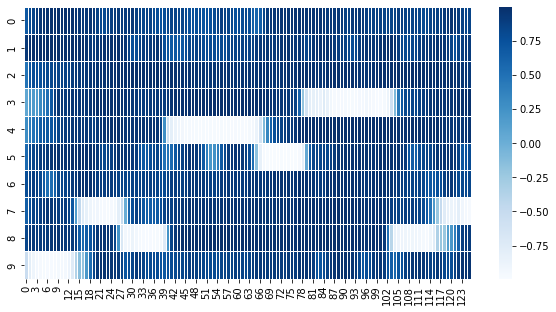

In [40]:
fig = plt.figure(figsize=(10,5))
sns.heatmap(data=np.squeeze(sample_lstm_enc_output.numpy()).T, linewidths=1, cmap='Blues')

_output of the `projection encoder` layer for the above sample image

---
#### Region encoder layer
__Vis. region encoder__

In [41]:
interesting_layer = 'region_encoder'

In [42]:
layer_weights = model.model.get_layer(interesting_layer).get_weights()
print(f"W shape : {layer_weights[0].shape} | b shape : {layer_weights[1].shape}")

W shape : (1, 126, 10) | b shape : (10,)


bais of the layer >  [-0.24927005 -0.24053329 -0.23511334 -0.20903099 -0.21785673 -0.23838717
 -0.14440271 -0.22303122 -0.2466086  -0.21664439]


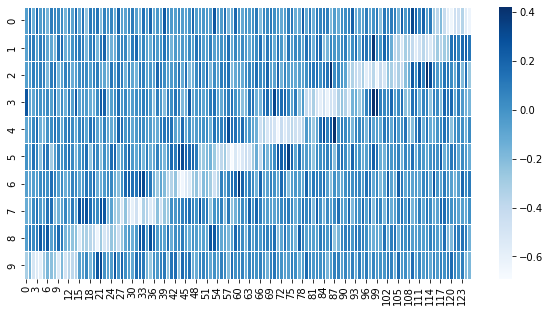

In [43]:
fig = plt.figure(figsize=(10,5))
sns.heatmap(data=np.squeeze(layer_weights[0]).T, linewidths=1, cmap='Blues')
print("bais of the layer > ", layer_weights[1])

__Vis. layer output__

In [44]:
interesting_layer = 'region_encoder'
grad_model = tf.keras.models.Model(inputs=[model.model.inputs], outputs=[model.model.get_layer(interesting_layer).output, model.model.output])

In [45]:
sample = tf.expand_dims(test_image, axis=0)
sample_lstm_enc_output, sample_output = grad_model(sample)
print(sample_lstm_enc_output.shape)

(1, 10, 10)


<AxesSubplot:>

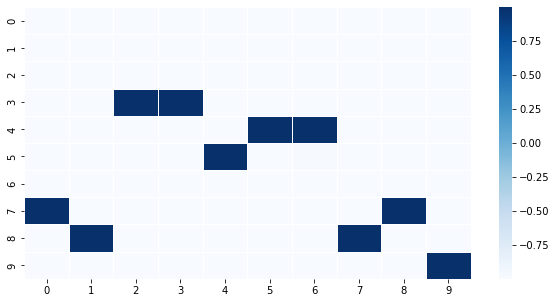

In [46]:
fig = plt.figure(figsize=(10,5))
sns.heatmap(data=np.squeeze(sample_lstm_enc_output.numpy()), linewidths=1, cmap='Blues')

---

In [47]:
tf.argmax(sample_output[0], axis=1)

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([7, 8, 3, 3, 5, 4, 4, 8, 7, 9], dtype=int64)>

In [48]:
def pred_eval_plot(pred_heatmap, image, figsize=(10, 10)):
    fig, axes = plt.subplots(2, 1, figsize=figsize,)
    sns.heatmap(ax=axes[0], data=pred_heatmap, linewidths=1, cbar=False, cmap='Blues')
    axes[1].imshow(image, cmap='gray', aspect='equal')
    plt.show()

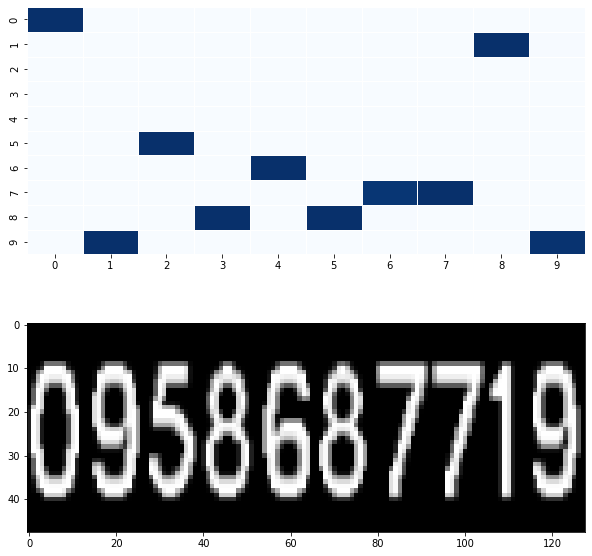

In [144]:
pred_eval_plot(sample_output[0, ...].numpy().T, test_image.numpy().T)

---